# Introduction
The ant colony optimization algorithms are a family of heuristic and probabilistic optimization algorithms based on swarm intelligence of simple computational agents. This kind of algorithms is widely used in the resolution of graph-based problem, and one common use for them is the resolution of the TSP. The algorithm simulates the paths taking by several decision agents known as "ants" during a number of determined iterations


The code presented int his blog was adapted from :

Wong, C. (2020) Black Desert Online Worker Optimization. Available at : https://cwong8.github.io/projects/BDO_Optimization/optimization/ Accesed: February 25 2020.

# Data representation
The two most common ways to represent graphs are adjacency lists or weight matrix. Because the TSP is represented by a weighted undirected graph, is convenient to represent an instance of the problem using a weight matrix, that represents the distances between each node of the graph. In pythom, a very simple instance of the TSP could be represented by something like this:

```
distances = np.array([[np.inf, 2, 2, 5, 7],
                      [2, np.inf, 4, 8, 2],
                      [2, 4, np.inf, 1, 3],
                      [5, 8, 1, np.inf, 2],
                      [7, 2, 3, 2, np.inf]])
```



# Data Import

In [ ]:
!git clone https://github.com/juan-carvajal/TSP_Data.git

Cloning into 'TSP_Data'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [ ]:
distances = np.array([[np.inf, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5],
                      [1, np.inf, 1, 1, 1, 1, 1],
                      [6, 6, np.inf, 6, 6, 6, 6],
                      [2.5, 2.5, 2.5, np.inf, 2.5, 2.5, 2.5],
                      [1.5, 1.5, 1.5, 1.5, np.inf, 1.5, 1.5],
                      [3, 3, 3, 3, 3, np.inf, 3],
                      [5, 5, 5, 5, 5, 5,np.inf]])
pheromone1 = np.array([300000, 5000000, 458333.3, 380000, 1233333, 1083333, 790000])
print(distances.shape)
print(pheromone1)
pheromone = np.ones(7) / len(distances)
print(pheromone)

(7, 7)
[ 300000.  5000000.   458333.3  380000.  1233333.  1083333.   790000. ]
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


shortest_path: ([(1, 5), (5, 4), (4, 3), (3, 0), (0, 6), (6, 2), (2, 1)], 21.5)
0


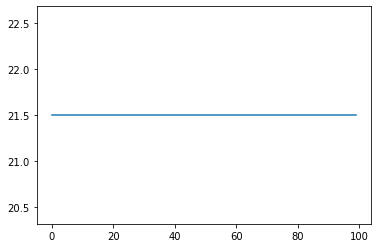

In [6]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice
from math import sqrt
import matplotlib.pyplot as plt
import json

dist = 0

class AntColony(object):

    def __init__(self, distances, pheromone,  n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        Example:
            ant_colony = AntColony(distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        # self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.pheromone = np.copy(pheromone)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        distance_logs=[]
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            distance_logs.append(all_time_shortest_path[1])                      
        return all_time_shortest_path,distance_logs

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                # self.pheromone[move] += 1.0 / self.distances[move]
                self.pheromone[move]  / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            # path = self.gen_path(rn.randrange(7))
            path = self.gen_path(1)
            
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        dist = 0
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            dist += self.distances[prev, move]
            
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started   
        
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = (pheromone ** self.alpha) * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move


#Static TSP Instance
distances = np.array([[np.inf, 1, 6, 2.5, 1.5, 3, 5],
                      [2.5, np.inf, 6, 2.5, 1.5, 3, 5],
                      [2.5, 1, np.inf, 2.5, 1.5, 3, 5],
                      [2.5, 1, 6, np.inf, 1.5, 3, 5],
                      [2.5, 1, 6, 2.5, np.inf, 3, 5],
                      [2.5, 1, 6, 2.5, 1.5, np.inf, 5],
                      [2.5, 1, 6, 2.5, 1.5, 3,np.inf]])
pheromone = np.array([[np.inf, 5000000, 2750000, 950000, 1850000, 3250000, 3950000],
                      [750000, np.inf, 2750000, 950000, 1850000, 3250000, 3950000],
                      [750000, 5000000, np.inf, 950000, 1850000,3250000, 3950000],
                      [750000, 5000000, 2750000, np.inf, 1850000, 3250000, 3950000],
                      [750000, 5000000, 2750000, 950000, np.inf, 3250000, 3950000],
                      [750000, 5000000, 2750000, 950000, 1850000, np.inf, 3950000],
                      [750000, 5000000, 2750000, 950000, 1850000, 3250000, np.inf]
                     ])

#Dinamic TSP Instance, changing the value of n_nodes will change the
#Instance size
# n_nodes=100
# dist=lambda x,y: sqrt(((x[0]-y[0])**2)+((x[1]-y[1])**2))
# l=[(rn.random()*1000,rn.random()*1000) for i in range(n_nodes)]
# distances=np.array([[np.inf if i==j else dist(l[i],l[j]) for i in range(len(l))] for j in range(len(l))])




#Presolved TSP Instance
# with open("TSP_Data/gr120.json", "r") as tsp_data:
#     tsp = json.load(tsp_data)

# distances = tsp["DistanceMatrix"]
# tour_size=7
# for i in range(tour_size):
#   distances[i][i]=np.inf
# distances=np.array(distances)




ant_colony = AntColony(distances, pheromone, 100, 50, 100, 0.7, alpha=1, beta=1)
shortest_path,log = ant_colony.run()
print ("shortest_path: {}".format(shortest_path))
print(dist)
plt.plot(log)
plt.show()